# ECON 326: Issues in Regression using R

* **Authors**: COMET Team (Emrul Hasan, Jonah Heyl, Shiming Wu)
* **Last update**: 16 August 2022
___
## Outline

### Prerequisites

* Multiple regression
* Simple regression
* Data analysis and introduction

### Outcomes

* Understand the origin and meaning of multicollinearity in regression models
* Perform simple tests for multicollinerarity using VIF
* Be able to demonstrate common methods to fix or resolve collinear data
* Understand the origin and meaning of heteroskedasticity in regression models
* Perform a variety of tests for heteroskedasticity
* Compute robust standard errors for regression models
* Understand other techniques for resolving heteroskedasticity in regression models

### Notes

Note that the data in this exercise is provided under the Statistics Canada Open License:
> <span id="fn1">[<sup>1</sup>](#fn1s)Statistics Canada, Survey of Financial Security, 2019, 2021. Reproduced and distributed on an "as is" basis with the permission of Statistics Canada.Adapted from Statistics Canada, Survey of Financial Security, 2019, 2021. This does not constitute an endorsement by Statistics Canada of this product.</span>

> <span id="fn2">[<sup>2</sup>](#fn2s)Stargazer package is due to: Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer </span>

In [34]:
#load the data and set it up

library(tidyverse)
library(haven)
#library(sandwich)
library(lmtest)

#install.packages("stargazer")  #un-comment this and run this line if you don't have stargazer installed
library(stargazer)

source("hands_on_tests_4.r")
#source("sandwich.r")

Warning message:
“package ‘lmtest’ was built under R version 4.1.2”
Loading required package: zoo

Warning message:
“package ‘zoo’ was built under R version 4.1.3”

Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Warning message:
“package ‘stargazer’ was built under R version 4.1.2”

Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


Warning message:
“package ‘testthat’ was built under R version 4.1.3”

Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches




In [32]:
#this code block is broken up and explained in module 1

SFS_data <- read_dta("../datasets/SFS_2019_Eng.dta")
SFS_data <- rename(SFS_data,age= pagemieg)
SFS_data <- filter(SFS_data, !is.na(SFS_data$pefmtinc))  
SFS_data <- rename(SFS_data, income_before_tax = pefmtinc) 
SFS_data <- rename(SFS_data, income_after_tax = pefatinc)
SFS_data <- rename(SFS_data, wealth = pwnetwpg)
SFS_data <- rename(SFS_data, gender = pgdrmie)
SFS_data <- rename(SFS_data, education = peducmie)
SFS_data<-SFS_data[!(SFS_data$education=="9"),]
SFS_data$education <- as.numeric(SFS_data$education)
SFS_data <- SFS_data[order(SFS_data$education),]
SFS_data$education <- as.character(SFS_data$education)
SFS_data$education[SFS_data$education == "1"] <- "Less than high school" 
SFS_data$education[SFS_data$education == "2"] <- "High school"
SFS_data$education[SFS_data$education == "3"] <- "Non-university post-secondary"
SFS_data$education[SFS_data$education == "4"] <- "University"
SFS_data$gender <- as_factor(SFS_data$gender) 
SFS_data$education <- as_factor(SFS_data$education)

In [6]:
SFS_data <- SFS_data %>% #some data cleaning
               mutate(ln_income_before_tax = log(income_before_tax))
SFS_data <- filter(SFS_data, !is.na(SFS_data$income_before_tax))
SFS_data <- filter(SFS_data, !is.na(SFS_data$income_after_tax))
glimpse(SFS_data)

Warning message in .fn(vec_data(.x), ...):
“NaNs produced”


Rows: 10,141
Columns: 101
$ pefamid              <chr> "00014", "00017", "00025", "00032", "00034", "000…
$ pweight              <dbl> 634.8358, 671.6546, 1367.6644, 2824.0936, 1106.10…
$ age                  <chr> "08", "12", "04", "10", "14", "14", "14", "13", "…
$ PAS1MRAG             <dbl+lbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ PAS1MRG1             <dbl+lbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ PAS1MRG2             <dbl+lbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ PASR1MFA             <dbl+lbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ PASR1MR              <dbl+lbl> NA, NA, NA,  2, NA, NA, NA, NA, NA, NA,  2, N…
$ pasrbuyg             <dbl+lbl>  6, NA, NA,  5,  2,  5,  5, NA, NA, NA,  3,  …
$ pasrcnmg             <dbl+lbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ pasrcon              <dbl+lbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, …
$ pasrcst              <dbl+lbl>     NA,     NA,     NA, 135000,  14500, 13500…
$ pasrcurg    

In this notebook, we will explore several important issues in multiple regression models, and explore how to identify, evaluate, and correct them where appropriate.  It is important to remember that there can be many other issues that arise in specific regression models; as you learn more about econometrics and create your own research questions, different issues will arise.  Consider these as "examples" for some of the most common issues that arise in regression models.

## Part 1: Multicollinearity

Multi-collinearity is a surprisingly common issue in applied regression analysis, where several explanatory variables are correlated to each other. For example, suppose we are interested at regressing one's marriage rate against years of education and annual income. In this case, the two explanatory variables income and years of education are highly correlated. It refers to the situation where a variable is "overdetermined" by the other variables in a model, which will result in less reliable regression output. For example, if we have a high coefficient on education. How certain are we that this coefficient was not the result of having a high annual income as well? Let's look at this problem mathematically; in calculating an OLS estimation, you are estimating a relationship like:

$$Y_i = \beta_a + \beta_1 X_1 + \epsilon_i$$

You find the estimates of the coefficients in this model using OLS; i.e. solving an equation like:

$$ \min_{b_0, b_1} \sum_{i=1}^n(Y_i - b_0 -b_1 X_i)^2 $$

Under the OLS regression assumptions, this has a unique solution; i.e you can find unique values for $b_0$ and $b_1$.  

However, what if you wrote an equation like this:
 $$\beta a=\beta_0+\beta_1 $$
 We can then rewrite  as $$Y_i = \beta_0 + \beta_1 + \beta_2 X_i + \epsilon_i$$


This _seems_ like it would be fine, but remember what you are doing: trying to find a _line_ of best fit.  The problem is that this equation does not define a unique line; the "intercept" is $\beta_0 + \beta_1$.  There are two "parameters" ($\beta_0, \beta_1$) for a single "characteristics" (the intercept).  This means that the resulting OLS problem:

$$ \min_{b_0, b_1, b_2} \sum_{i=1}^n(Y_i - b_0 -b_1 -b_2 X_i)^2 $$

Does not have a unique solution.  In algebraic terms, it means you can find many representations of a line with two intercept parameters.  This is referred to in econometrics as a lack of **identification**; multicollinearity is one way that identification can fail in regression models.

You can see this in the following example, which fits an OLS estimate of ``wealth`` and ``income_before_tax`` then compares the fit to a regression with two intercepts.  Try changing the values to see what happens.

> **Note**: Make sure to understand what the example below is doing. Notice how the results are exactly the same, no matter what the value of ``k`` is?

In [15]:
reg <- lm(wealth ~ income_before_tax, data = SFS_data)



b_0 <- reg$coef[[1]]
b_1 <- reg$coef[[2]]

resid <- SFS_data$wealth - b_0 - b_1*SFS_data$income_before_tax

#print(paste("Regression Coefficients:", round(b_0,2),"and",round(b_1,2)))
print(paste("1st Sum of Residuals:", round(sum(resid),10)))


k <- 90 #change me! 

b_0 = (reg$coef[[1]])/2 - k
b_1 = (reg$coef[[1]])/2 + k 
b_2 = reg$coef[[2]]

resid <-SFS_data$wealth - b_0 - b_1 - b_2*SFS_data$income_before_tax


print(paste("2nd Sum of Residuals:", round(sum(resid),10)))


[1] "1st Sum of Residuals: -2.9595e-06"
[1] "2nd Sum of Residuals: -2.9189e-06"


The sum of residuals between on the 1st and 2nd regression should be different. After all, they are different regressions with different coefficients. 


Okay, you're probably thinking, that makes sense - but just don't write down an equation like that.  After all, it seems somewhat artificial that we added an extra intercept term.

However, multicollinearly can occur with _any_ set of variables in the model; not just the intercept.  For example, suppose you have a multiple regression:

$$Y_ i = \beta_0 + \beta_1 X_{1,i} + \beta_2  X_{2,i} + \beta_3  X_{3,i} + \epsilon_i$$

What would happen if there was a relationship between $X_1, X_2$ and $X_3$ like:

$$X_{1,i} = 0.4 X_{2,i} + 12 X_{3,i}$$  

When, we could then re-write the equation as:

$$Y_ i = \beta_0 + \beta_1 (0.4 X_{2,i} + 12 X_{3,i}) + \beta_2  X_{2,i} + \beta_3  X_{3,i} + \epsilon_i$$

$$\implies Y_ i = \beta_0 + (\beta_2 + 0.4 \beta_1)  X_{2,i} + (\beta_3 + 12 \beta_1)X_{3,i} + \epsilon_i$$

The same problem is now occuring, but with $X_2$ and $X_3$: the slope coefficients depend on a free parameter ($\beta_1$).  You cannot uniquely find the equation of a line (c.f. plane) with this kind of equation. 

Basically what is happening, is you are trying to solve a system of equations for 3 variables (or n variables), but only 2 (or n-1) are used in the equation (are independent). So what would you do, well you would leave one of the dependent variables out, so you could solve for all of your variables, this is exactly what R does.

You can also intuitively see the condition here: multicollinearity occurs when you can express one variable as a _linear_ combination of the other variables in the model.

* This is sometimes referred to as **perfect multicollinearity**, since the variable is _perfectly_ expressed as a linear combination of the other variable.
* The linearity is important because this is a linear model; you can have similar issues in other models, but it has a special name in linear regression

### Perfectly Multicollinearity in Models

In general, most statistical packages (like R) will automatically detect, warn, and remove perfectly multicollinear variables from a model; this is because the algorithm they use to solve problems like the OLS estimation equation detects the problem and avoids a "crash".  This is fine, from a mathematical perspective - since mathematically the two results are the same (in a well-defined sense, as we saw above).

However, from an economic perspective this is very bad - it indicates that there was a problem with the _model_ that you defined in the first place.  Usually, this means one of three things:

1. You included a set of variables which were, in combination, identical.  For example, including "family size" and then "number of children" and "number of adults" in a regression
2. You did not understand the data well enough, and variables had less variation than you thought they did - conditional on the other variables in the model.  For example, maybe you thought people in the dataset could have both graduate and undergraduate degrees - so there was variation in "higher than high-school" but that wasn't true
3. You wrote down a model which was poorly defined in terms of the variables.  For example, you including all levels of a dummy variable, or included the same variable measured in two different units (wages in dollars and wages in 1000s of dollars).

In all of these cases, you need to go back to your original regression model and re-evaluate what you are trying to do in order to simplify the model or correct the error.  

Consider the following regression model, in which we want to study whether or not there is a penalty for families led by someone who is younger is the SFS Data:

In [16]:
SFS_data <- SFS_data %>%
    mutate(ya = case_when(
        education == "Less than high school"  ~ "Yes",
        education == "High school" ~ "Yes",
        education == "Non-university post-secondary" ~ "No", #this is for all other cases
        TRUE ~ "No" #this is for all other cases
    )) %>%
    mutate(ya = as_factor(ya))

regression2 <- lm(income_before_tax ~ ya +education , data = SFS_data)

summary(regression2)


Call:
lm(formula = income_before_tax ~ ya + education, data = SFS_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-183803  -57016  -21803   29984 3163197 

Coefficients: (1 not defined because of singularities)
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                               38306       3464  11.058  < 2e-16 ***
yaNo                                      98497       3976  24.770  < 2e-16 ***
educationHigh school                      31710       4290   7.392 1.56e-13 ***
educationNon-university post-secondary   -50440       2998 -16.823  < 2e-16 ***
educationUniversity                          NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 120800 on 10137 degrees of freedom
Multiple R-squared:  0.07631,	Adjusted R-squared:  0.07603 
F-statistic: 279.1 on 3 and 10137 DF,  p-value: < 2.2e-16


Can you see why the multi-collinearity is occurring here?  Try to write down an equation which points out what the problem is in this regression - why is it multi-collinear?  How could you fix this problem by changing the model?

> _Think Deeper_: You will notice, above, that it excluded the "University" education.  Did it have to exclude that one?  Could it have excluded another one instead?  What do you think?

### Imperfect Multicollinearity

A related issue to perfect multicollinearity is "near" (or **imperfect**) multicollinearity.  If you recall from the above, perfect multicollinearity occurs when you have a relationship like:

$$X_{1,i} = 0.4 X_{2,i} + 12 X_{3,i}$$  

Notice that in this relationship it holds _for all_ values of $i$.  However, what if it held for _nearly_ all $i$ instead?  In that case, we would still have a solution to the equation... but there would be a problem.  Let's look at this in the simple regression case.  


$$Y_i = \beta_0 + \beta_1 X_i + \epsilon_i$$

Now, let's suppose that $X_i$ is "almost" collinear with $\beta_0$.  To be precise, suppose that $X_i = 15$ for $k$-% of the data ($k$ will be large) and $X_i = 20$ for $(1-k)$-% of the data.  This is _almost_ constant, and so it is _almost_ collinear with $\beta_0$ (the constant).  Let's also make the values of $Y_i$ so that $Y_i(X_i) = X_i + \epsilon_i$ (so $\beta_1 = 1$), and we will set $\sigma_Y = 1$

This implies that (applying some of the formulas from class):

$$\beta_1 = \frac{Cov(X_i,Y_i)}{Var(X_i)} = 1$$

$$s_b = \frac{1}{\sqrt{n-2}}\sqrt{\frac{1}{r^2}-1}$$

$$r = \frac{\sigma_X}{\sigma_Y}$$

As you can see, when $Var(X_i)$ goes down, $\sigma_X$ falls, and the value of $r$ falls; intuitively, when $k$ rises, the variance will go to zero, which makes $r$ go to zero as well (since there's no variation).  You can then see that $s_b$ diverges to infinity.  

We can make this more precise.  In this model, how does $Var(X_i)$ depend on $k$?  Well, first notice that $\bar{X_i} = 15\cdot k + 20 \cdot (1-k)$.  Then,

$$Var(X_i) = (X_i - \bar{X_i})^2 = k (15 - \bar{X_i})^2 + (1-k)(20 - \bar{X_i})^2$$

$$\implies Var(X_i) = 25[k(1-k)^2 + (1-k)k^2]$$

Okay, that looks awful - so let's plot a graph of $s_b$ versus $k$ (when $n = 1000$):

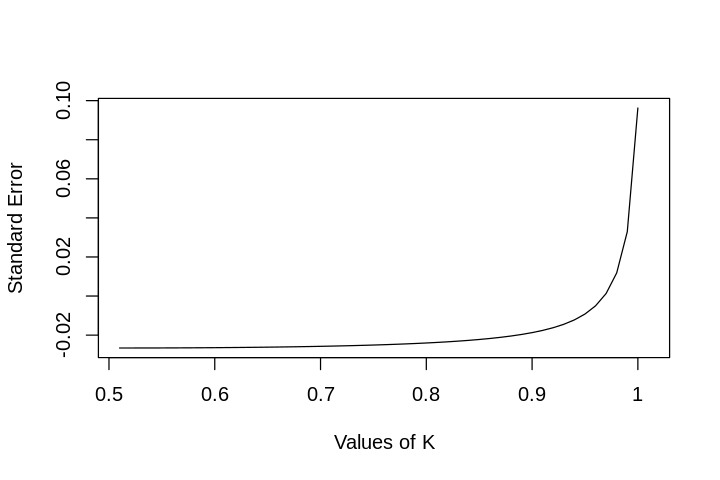

In [36]:
options(repr.plot.width=6,repr.plot.height=4)

r = 0.01 

eq = function(k){(1/sqrt(1000-2))*(1/(25*(k*(1-k)^2 + (1-k)*k^2))-1)}
s = seq(0.5, 1.00, by = r)
n = length(s)

plot(eq(s), type='l',  xlab="Values of K", ylab="Standard Error", xaxt = "n")
axis(1, at=seq(0, n-1, by = 10), labels=seq(0.5, 1.00, by = 10*r))

# You will notice that the plot actually diverges to infinity
# Try making R smaller to show this fact!
#Notice the value at 1 increases

Why does this happen?  The reason actually has to do with _information_.

When you estimate a regression, you are using the variation in the data to estimate each of the parameters.  As the variation falls, the estimation gets less and less precise, because you are using less and less data to make an evaluation.  The magnitude of this problem can be quantified using the **VIF** or **variance inflation factor** for each of the variables in question.Graphically you can think of regression as drawing a best fit line through data points. Now if the variance is $0$ in the data, there is just one data point.If you remember from high school you need two points to draw a line, so with $0$ variance the OLS problem becomes ill-defined.

We can calculate this directly in R by using the ``vif`` function.  Let's look at the collinearity in our model:

In [29]:
regression2 <- lm(wealth ~  income_before_tax +income_after_tax, data = SFS_data)

summary(regression2)




Call:
lm(formula = wealth ~ income_before_tax + income_after_tax, data = SFS_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-16142648   -624841   -325170    186684  27722471 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       2.308e+05  2.705e+04   8.531  < 2e-16 ***
income_before_tax 1.827e+00  4.493e-01   4.066 4.82e-05 ***
income_after_tax  7.242e+00  6.959e-01  10.406  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1549000 on 10138 degrees of freedom
Multiple R-squared:  0.2152,	Adjusted R-squared:  0.2151 
F-statistic:  1390 on 2 and 10138 DF,  p-value: < 2.2e-16


In [35]:
cat("varraince infaltion factor of  income after tax on wealth",vif(regression2,SFS_data$income_after_tax,SFS_data$wealth),'\n')
cat("varraince infaltion factor of  income before tax on wealth",vif(regression2,SFS_data$income_before_tax,SFS_data$wealth),'\n')
cat("varraince infaltion factor of  income before tax on income after tax",vif(regression2,SFS_data$income_before_tax,SFS_data$income_after_tax),'\n')

varraince infaltion factor of  income after tax on wealth 1.860563 
varraince infaltion factor of  income before tax on wealth 1.83414 
varraince infaltion factor of  income before tax on income after tax 26.45109 


Notice the extremely large VIF.  This would indicate that you have a problem with collinearity in your data.

> _Think Deeper_:  What happens to the VIF as ``k`` changes?  Why?  Can you explain?

There are no "hard" rules for what makes a VIF too large - you should think about your model holistically, and use it as a way to investigate whether you have any problems with your model evaluation and analysis.

## Part 2: Heteroskedasticity

**Heteroskedasticity** (Het-er-o-sked-as-ti-city) is another common problem in many economic models.  It refers to the situation in which the distribution of the residuals changes as the explanatory variables change. Usually, we could visualize this problem by drawing a residual plot and a fan or cone shape indicates the presence of heteroskedasticity. For example, consider this regression:

Don't know how to automatically pick scale for object of type haven_labelled/vctrs_vctr/double. Defaulting to continuous.

Don't know how to automatically pick scale for object of type haven_labelled/vctrs_vctr/double. Defaulting to continuous.



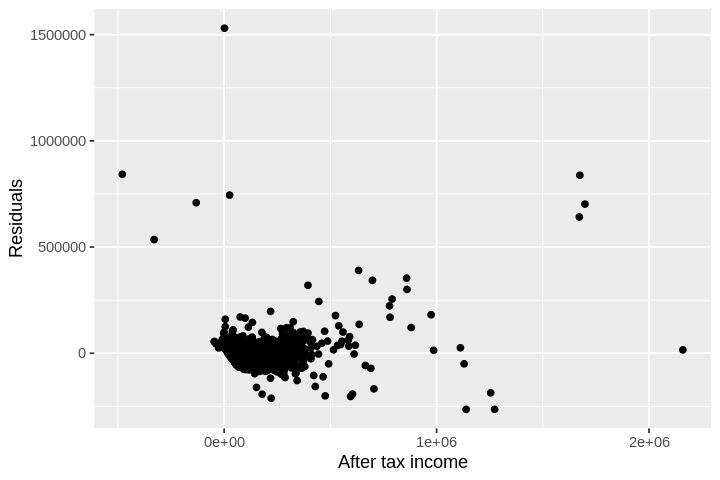

In [37]:
regression3 <- lm(income_before_tax ~ income_after_tax, data = SFS_data)

ggplot(data = SFS_data, aes(x =income_after_tax, y = regression3$residuals)) + geom_point() + labs(x = "After tax income", y = "Residuals")

This obviously does not look like a distribution which is unchanging as market income changes.  This is a good "eyeball test" for heteroskedasticty.  Why does heteroskedasticity arise?  For many reasons:

1.  It can be a property of the data; it just happens that some values show more variation, due to the process which creates the data.  One of the most common ways this can arise is where there are several different economic processes creating the data.  

2.  It can be because of an unobserved variable.  This is similar to above; if we can quantify that process in a variable or a description, we have left it out.  This could create bias in our model, but it will also show up in the standard errors in this way.
3.  It can be because of your model specification.  Models, by their very nature, can be heteroskedastic (or not); we will explore one important example later in this worksheet.
4.  There are many other reasons, which we won't get into here.

Whatever the reason it exists, you need to correct for it - if you don't, while your coefficients will be OK, your standard errors will be incorrect.  You can do this in a few ways.  The first way is to try to change your variables that the "transformed" model (a) makes economic sense, and (b) no longer suffers from heteroskedasticity.  For example, perhaps a _log-log_ style model might work here:


Warning message in .fn(vec_data(.x), ...):
“NaNs produced”
Warning message in .fn(vec_data(.x), ...):
“NaNs produced”


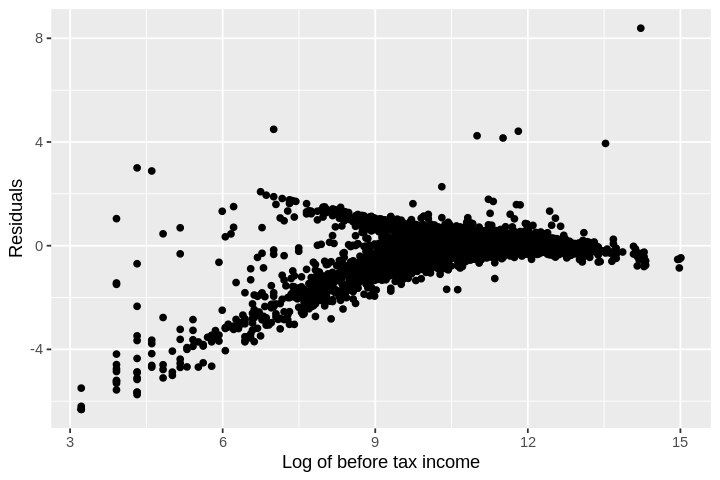

In [38]:
SFS_data <- SFS_data %>%
               mutate(lnincome_before_tax = log(income_before_tax))

SFS_data <- SFS_data %>%
               mutate(lnincome_after_tax = log(income_after_tax))

#getting rid of NAs
temp_data <- filter(SFS_data, !is.na(SFS_data$lnincome_before_tax))
temp_data <- filter(temp_data, !is.na(temp_data$lnincome_after_tax))
#You might need to comment out these two lines below, depending on your kernal of r
temp_data <- filter(temp_data, temp_data$lnincome_after_tax!=-Inf)
temp_data <- filter(temp_data, temp_data$lnincome_before_tax!=-Inf)


regression4 <- lm(lnincome_before_tax ~ lnincome_after_tax, data = temp_data)

ggplot(data = temp_data, aes(x = lnincome_before_tax, y = regression4$residuals)) + geom_point() + labs(x = "Log of before tax income", y = "Residuals")

> _Think Deeper_: Does the errors of this model seem homoskedastic?

As you can see, that didn't work out.  This is pretty typical: when you transform a model by changing the variables, what you are really doing is adjusting how you think the data process should be described so that it's no longer heteroskedastic.  If you aren't correct with this, you won't fix the problem.

For example, in a _log-log_ model, we are saying "there's a multiplicative relationship"... but that probably doesn't make sense here.  This is one of the reasons why data transformations are not usually a good way to fix this problem unless you have a very clear idea of what the transformation _should_ be.

The most robust (no pun intended) way is to simply use standard errors which are robust to heteroskedasticity.  There are actually a number of different versions of these (which you don't need to know about), but they are all called **HC** or **hetereoskedasticity-corrected** standard errors.  In economics, we typically adopt White's versions of these (called **HC1** in the literature); these are often referred to in economics papers as "robust" standard errors (for short).

This is relatively easy to do in R.  Basically, you run your model, as normal, and then re-test the coefficients to get the correct error using the ``coeftest`` command, but specifying which kind of errors you want to use.  Here is an example:

In [39]:
regression5 <- lm(income_before_tax ~ income_after_tax, data = SFS_data)

summary(regression5)

coeftest(regression5, vcov = vcovHC(regression5, type = "HC1"))


Call:
lm(formula = income_before_tax ~ income_after_tax, data = SFS_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-264118  -13229    1171   12497 1530641 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -3.336e+04  4.977e+02  -67.03   <2e-16 ***
income_after_tax  1.490e+00  4.189e-03  355.72   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 34230 on 10139 degrees of freedom
Multiple R-squared:  0.9258,	Adjusted R-squared:  0.9258 
F-statistic: 1.265e+05 on 1 and 10139 DF,  p-value: < 2.2e-16


ERROR: Error in vcovHC(regression5, type = "HC1"): could not find function "vcovHC"


As you can see, the standard errors (and significance tests) give different results; in particular, the HC1 errors are almost 10-times larger than the uncorrected errors.  In this particular model, it didn't make much of a different to the conclusions (even though it changed the $t$ statistics a lot), but it can sometimes change your results.

### Testing for Heteroskedasticity

You can also perform some formal tests for heteroskedasticity.  We learned about two of them in class:

1.  White's Test, which relies on performing a regression using the residuals
2.  Breusch-Pagan Test, which also relies on performing a simpler regression using the residuals

Both of them are, conceptually, very similar.  Let's try (2) for the above regression:

In [41]:
regression2 <- lm(income_before_tax ~ income_after_tax, data = SFS_data) #we hould understand this by now

SFS_data$resid_sq <- (regression2$residuals)^2 #get the residuals then square it

regression3 <- lm(resid_sq ~ income_after_tax, data = SFS_data) #make the residules a function of X

summary(regression3)


Call:
lm(formula = resid_sq ~ income_after_tax, data = SFS_data)

Residuals:
       Min         1Q     Median         3Q        Max 
-8.580e+10 -1.914e+09 -1.780e+08  1.076e+09  2.345e+12 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -2.383e+09  3.965e+08   -6.01 1.92e-09 ***
income_after_tax  4.096e+04  3.337e+03   12.27  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.727e+10 on 10139 degrees of freedom
Multiple R-squared:  0.01464,	Adjusted R-squared:  0.01454 
F-statistic: 150.6 on 1 and 10139 DF,  p-value: < 2.2e-16


Inspecting the results, we can see from the $F$-statistic that we can strongly reject the assumption of homoskedasticity. This is denoted by the 3 asterisk. This data looks like it's heteroskedastic, because the residuals can be predicted using the explanatory variables.

There is one very important note: 

* If you **fail** one of these tests, it implies that your data is heteroskedastic
* If you **pass** one of these tests, it _does not_ imply that your data is homoskedastic (i.e. not heteroskedastic)

This is because these are statistical tests, and the null hypothesis is "not heteroskedastic".  Failing to reject the null does not mean that the null hypothesis is correct - it just means that you can't rule it out.  This is one of the reasons many economists recommend that you _always_ use robust standard errors unless you have a really compelling reason to believe otherwise.

### Linear Probability Models

How can a model naturally have heteroskedastic standard errors?  It turns out that many common, and important, models have this issue.  In particular, the **linear probability** model has this problem.  If you recall, a linear probability model is a linear regression in which the dependent variable is a dummy.  For example:

$$D_i = \beta_0 + \beta_1 X_{1,i} + \beta_2 X_{2,i} + \epsilon_i$$

These model are quite useful because the coefficients have the interpretation as being the change in the probability of the dummy condition occurring.  For example, we previously regressed ``gender`` (of male or female) in these models to investigate the wealth gap.  However, this can easily cause a problem when estimated using OLS - the value of $D_i$ must be 0 or 1, and the fitted values (which are probabilities) must be between 0 and 1.

However, _nothing_ in the OLS model forces this to be true.  If you estimate a value for $\beta_1$, if you have an $X_{1,i}$ that is high or low enough, the fitted values will be above or below 1 or 0 (respectively).  This implies that _mechanically_ you have heteroskedasticity because high or low values of the explanatory variables will ALWAYS fit worse than intermediate values.  For example, let's look at the fitted values from this regression:


Call:
lm(formula = M_F ~ income_before_tax, data = SFS_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4720 -0.4123 -0.3563  0.5697  1.4120 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        4.475e-01  6.060e-03   73.84   <2e-16 ***
income_before_tax -5.209e-07  3.833e-08  -13.59   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.485 on 10139 degrees of freedom
Multiple R-squared:  0.01789,	Adjusted R-squared:  0.01779 
F-statistic: 184.7 on 1 and 10139 DF,  p-value: < 2.2e-16


Don't know how to automatically pick scale for object of type haven_labelled/vctrs_vctr/double. Defaulting to continuous.



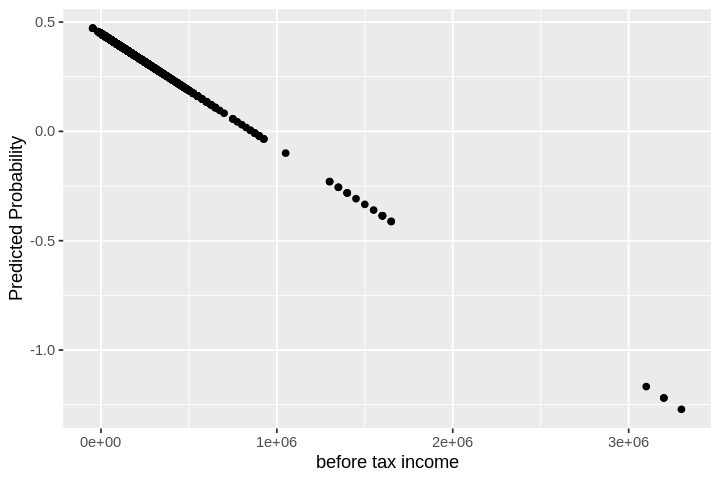

In [42]:
#SFS_data$dummy_immstat = as.numeric(SFS_data$gender) - 1 #what is this line of code doing?  

SFS_data <- SFS_data %>%
    mutate(M_F = case_when(
        gender == "Male"  ~ 0,
        gender == "Female" ~ 1,
    ))

regression6 <- lm(M_F ~ income_before_tax, data = SFS_data)

SFS_data$fitted <- predict(regression6, SFS_data)

summary(regression6)

ggplot(data = SFS_data, aes(x = income_before_tax, y = fitted)) + geom_point() + labs(x = "before tax income", y = "Predicted Probability")



Notice how that as $y$ gets larger as the fitted value drops.  If someone has an income of over 1 million dollars, they would be predicted to have a negative probability of being a female - which is impossible.

This is why you _always_ must use robust standard errors in these models - even if a test says otherwise. Let's think about what is happening here, well remember the example of  imperfect collinearity, we're the was $1-k$ chance of $x$ being 15 and k of $x$ being 20. Now remember x was co-linear to $\beta_0$, and this caused large standard errors. In this scenario the probability of a someone being female given they earn over a million dollars a year is very small. This because few female lead has household earn over a million dollars a year as a percent of the total households earning over a million dollars a year.

## Part 3: Exercises

In these exercises, you will get some hands-on experience with testing and correcting for heteroskedasticity and multicollinearity. You will also start to think about the mechanics and uses of non-linear regressions.

### Activity 1

Multicollinearity may seem to be an abstract concept, so let's explore this issue with a practical example. 

Suppose that we are looking to explore the relationship between a families income the gender of the major earner. For instance, we want to know whether families with higher incomes in Canada are more likely to be male. Recall that we have two measures of income: ``income_before_tax`` and ``income_after_tax``. Both measures of income are informative: ``income_before_tax`` refers to gross annual income (before taxes) that employers pay to employees; ``income_after_tax`` refers to net income after taxes have been deducted. 

Since they are both good measures of income, we decide to put them both in our regression:

$$M_F = \beta_0 + \beta_1 I_{bi} + \beta_2 I_{ai} + \epsilon_i$$

$M_F$ denotes the dummy variable for whether the person is male or female, $I_{ai}$ denotes income after taxes, and $I_{bi}$ denotes income before taxes.

### Short Answer 1

<em>Prompt:</em> What concern should we have about this regression equation? Explain your intuition.


<font color="red">Answer here in red

Before we continue, let's reduce the sample size of our data set to 200 observations. We will also revert ``gender`` into a numeric variable:

In [43]:
#Run this!
SFS_data200 <- head(SFS_data, 200) %>%
    mutate(M_F = as.numeric(gender)) #everyone in the first 200 obesrvations idenfide as, male or female (this is not true for the whole dataset)

### Activity 2

Run the regression described above.

<em>Tested Objects:</em> ``reg1``.

In [82]:

#Quiz 1

reg1 <- lm(M_F~income_before_tax+income_after_tax, data = SFS_data200) #fill me in

summary(reg1)


test_1() #test1


Call:
lm(formula = M_F ~ income_before_tax + income_after_tax, data = SFS_data200)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4985 -0.4009 -0.2592  0.5403  1.0070 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1.531e+00  7.959e-02  19.234   <2e-16 ***
income_before_tax -2.184e-07  2.140e-06  -0.102    0.919    
income_after_tax  -3.081e-06  2.739e-06  -1.125    0.262    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4705 on 197 degrees of freedom
Multiple R-squared:  0.05925,	Adjusted R-squared:  0.0497 
F-statistic: 6.204 on 2 and 197 DF,  p-value: 0.002439


[1] "5492ea03b542f2865d0889675db7c138"

Test passed 🥇
[1] "Success!"


### Short Answer 2

<em>Prompt:</em> What do you notice about the characteristics of the estimated regression? Does anything point to your concern being valid?

<font color="red">Answer here in red



Now, let's suppose we drop 50 more observations:

In [61]:
#Run this!
SFS_data150 <- head(SFS_data200, 150)

Run the regression model again and compare it with the previous regression.

<em>Tested Objects:</em> ``reg2``.

In [84]:
#Quiz 2


reg2 <- lm(M_F~income_before_tax+income_after_tax, data = SFS_data150) # fill me in

summary(reg2)


test_2() 


Call:
lm(formula = M_F ~ income_before_tax + income_after_tax, data = SFS_data150)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4666 -0.4049 -0.2612  0.5493  1.0054 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1.449e+00  9.050e-02  16.009   <2e-16 ***
income_before_tax -2.660e-06  2.452e-06  -1.085    0.280    
income_after_tax   1.514e-07  3.063e-06   0.049    0.961    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.471 on 147 degrees of freedom
Multiple R-squared:  0.05648,	Adjusted R-squared:  0.04364 
F-statistic:   4.4 on 2 and 147 DF,  p-value: 0.01394


[1] "0b9cf3c70995c397636b67404f48be2e"

Test passed 🎉
[1] "Success!"


### Short Answer 3

<em>Prompt:</em> What happened to the regression estimates when we dropped 50 observations? Does this point to your concern being valid?

<font color="red">Answer here in red</font>


Next, increase the sample size back to its full size and run the regression once again.

<em>Tested Objects:</em> ``reg3``

In [88]:
#Quiz 3
source("hands_on_tests_4.r")

reg3 <- lm(M_F ~income_before_tax+income_after_tax, data = SFS_data) #fill me in

summary(reg3)

test_3() #test2


Call:
lm(formula = M_F ~ income_before_tax + income_after_tax, data = SFS_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8249 -0.4124 -0.3458  0.5648  1.6254 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        4.761e-01  8.463e-03  56.260  < 2e-16 ***
income_before_tax  1.340e-07  1.406e-07   0.953     0.34    
income_after_tax  -1.054e-06  2.177e-07  -4.842 1.31e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4845 on 10138 degrees of freedom
Multiple R-squared:  0.02015,	Adjusted R-squared:  0.01996 
F-statistic: 104.3 on 2 and 10138 DF,  p-value: < 2.2e-16


Test passed 🌈
[1] "Success!"


### Short Answer 5

<em>Prompt:</em> Did this change eliminate the concern? How do you know?

<font color="red">Answer here in red </font>




Heteroskedasticity is another issue that researchers frequently deal with when they estimate regression models. Consider the following regression model:

$$I_i = \alpha_0 + \alpha_1 E_i + \alpha_2 G_i  + \epsilon_i$$

$I_i$ denotes before tax income, $E_i$ is level of education, $D_i$ is a dummy variable for being female.

### Short Answer 6 
<em>Prompt:</em> Should we be concerned about heteroskedasticity in this model? If so, what is the potential source of heteroskedasticity, and what do we suspect to be the relationship between the regressor and the error term?

<font color="red">Answer here in red


### Short Answer 7

<em>Prompt:</em> If we suppose that heteroskedasticity is a problem in this regression, what consequences will this have for our regression estimates?

<font color="red">Answer here in red </font>

Run the regression below, and graph the residuals against the level of schooling.

<em>Tested Objects:</em> ``reg5``. The graph will be graded manually.

Don't know how to automatically pick scale for object of type haven_labelled/vctrs_vctr/double. Defaulting to continuous.



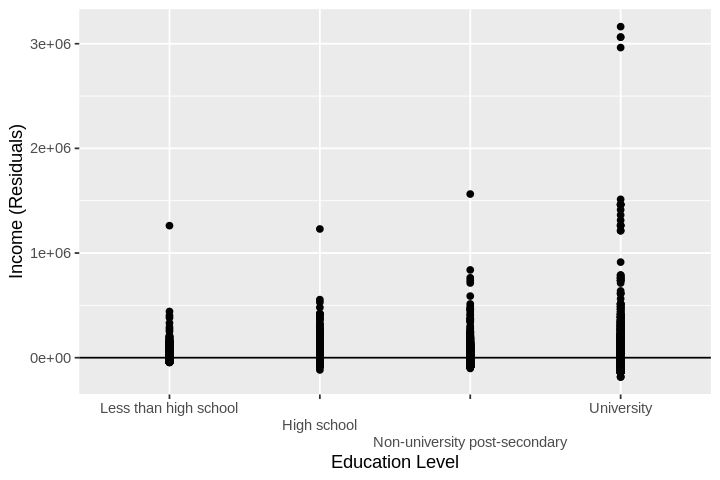

In [93]:
#Quiz 5


#Run the regression
reg5 <- lm(income_before_tax~education, data = SFS_data)

resiplot <- ggplot(reg5, aes(x = education, y = .resid)) + xlab("Education Level") + ylab("Income (Residuals)")
resiplot + geom_point() + geom_hline(yintercept = 0) + scale_x_discrete(guide = guide_axis(n.dodge=3))


### Short Answer 8

<em>Prompt:</em> Describe the relationship between education level and the residuals in the graph above. What does the graph tell us about the presence and nature of heteroskedasticity in the regression model?

<font color="red">Answer here in red:  </font>



To test for heteroskedasticity formally, let's perform the White Test. First, store the residuals from the previous regression in ``SFS_data``.

<em> Tested Objects: ``SFS_data`` (checks to see that residuals were added properly).

In [94]:
#Quiz 6

SFS_data <- mutate(SFS_data, resid = reg5$residuals)

head(SFS_data$resid, 10) #Displays the residuals in the dataframe

test_6() #test3

<labelled<double>[10]>: Market income.
          1           2           3           4           5           6 
  -305.8594 -37955.8594 -32055.8594  29194.1406 -15305.8594 -27305.8594 
          7           8           9          10 
-38305.8594 -31805.8594  -9305.8594 -38305.8594 

Labels:
 value      label
 1e+08 Valid skip
 1e+08 Don't know
 1e+08    Refusal
 1e+08 Not stated

Test passed 🥳
[1] "Success!"


Next, generate a variable for the squared residuals, then run the required auxiliary regression.

<em>Tested Objects:</em> ``WT`` (the auxiliary regression).

In [97]:
#Quiz 7
model=lm(income_before_tax~gender^2 + gender + education^2 +education+ education*gender, data = SFS_data) # fill me in
resid = reg5$residuals
rsq=(resid)^2



In [96]:
SFS_data$rsq=rsq

WT <- lm(rsq~ education + gender + education^2 + gender^2 + education*gender, data =SFS_data) # fill me in

summary(WT)


test_7() #test4



Call:
lm(formula = rsq ~ education + gender + education^2 + gender^2 + 
    education * gender, data = SFS_data)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.282e+10 -8.091e+09 -4.801e+09 -2.021e+09  9.963e+12 

Coefficients:
                                                      Estimate Std. Error
(Intercept)                                          3.489e+09  7.343e+09
educationHigh school                                 2.857e+09  9.100e+09
educationNon-university post-secondary               3.034e+09  8.812e+09
educationUniversity                                  3.933e+10  8.523e+09
genderFemale                                         1.696e+09  1.202e+10
educationHigh school:genderFemale                   -3.638e+09  1.487e+10
educationNon-university post-secondary:genderFemale -3.396e+08  1.435e+10
educationUniversity:genderFemale                    -3.456e+10  1.372e+10
                                                    t value Pr(>|t|)    
(Interce

Test passed 🥇
[1] "Success!"


### Short Answer 9

<em>Prompt:</em> What does the white test suggest?

### Activity 3

Finish filling in this table:

<table>
  <tr>
     <th>Formal Issue Name</th>
    <th>Problem</th>
      <th>Meaning</th>
      <th>Test</th>
    <th>Solution</th>
  </tr>
  <tr>
    <td>??? </td>
    <td>Incorrect Standard errors, which can lead to incorrect confidence intervals etc</td>
     <td>The distribution of residuals is not constant</td>
      <td> White's Test and  Breusch-Pagan: bptest() (for the Breuusch-pagan test)</td>
      <td>Add additional factors to regression or use robust standard errors</td>
  </tr>
      <tr>
    <td>Perfect Collinearity </td>
    <td>???</td>
     <td>One variable in the regression is a linear function of another variable in the regression</td>
      <td> Collinearity test on the model, ols_vif_tol(model) </td>
      <td>???</td>
  </tr>
      <tr>
    <td>Imperfect Collinearity </td>
    <td>The model will have very large standard erros. R may need to omit a varible</td>
     <td>One variable can almost be fully predict with a linear function of another variable in the model</td>
      <td> ??? </td>
      <td>Omit one of the co-linear variables, try using more data, another option is using a transformation(for instance taking logarithms).</td>
  </tr>
</table>




<span id="fn1">[<sup>1</sup>](#fn1s)Provided under the Statistics Canada Open License.  Adapted from Statistics Canada, Statistics Canada Open License (Public)
Adapted from Statistics Canada, 2021 Census Public Use Microdata File (PUMF). This does not constitute an endorsement by Statistics Canada of this product.</span>